In [1]:
# Periodic Table 
import mendeleev as mv 
from mendeleev.fetch import fetch_table 

# basic XRF physics 
from fisx import Elements 
import xraydb
# advanced XRF stuff that we do no need now   
#from fisx import Material
#from fisx import Detector
#from fisx import XRF 

# peak finding 
import scipy.signal as ssg
import scipy

# plotting 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import matplotlib.cm as cm 
import seaborn as sb

In [32]:
def _colorize(elem_select, crop=True): 
    '''High contrast standard color palette for list of elements *elem_select*.
    
    '''
    
    DEFAULT_COLOR = [0.4, 0.4, 0.9, 0.3] 
    
    # return single color tuple is argument is string, e.g. 'Fe' 
    return_single_color_tuple = False 
    if type(elem_select) == str:
        return_single_color_tuple = True 
        elem_select = [elem_select]
        
    # create standard palette for Hydrogen(Z=1) to Organesson(Z=117) 
    palette = []
    for tone in ['pastel', 'bright', 'deep', 'dark'] * 3:  
        palette.extend(sb.palettes.color_palette(tone))
    palette = np.array(palette)[0:118]
    # and include unity alpha channel
    palette = np.c_[palette, np.ones(len(palette))]
    
    # return full color palette if argument is empty list 
    if len(elem_select) == 0:
        return palette
 
    else: 
        # find index position (Z-1) of elements   
        ptable_indices = [mv.element(e).atomic_number - 1 for e in elem_select]
        
        # initialize all element color list with light blue grey 
        colors = np.zeros([118, 4])
        colors[:] = DEFAULT_COLOR 
        
        # colorize selected elements with standard palette color 
        colors[ptable_indices] = palette[ptable_indices]
        
        # skip colors for non selected elements 
        if crop: 
            colors = palette[ptable_indices]

            # for single element just return color tuple 
            if return_single_color_tuple: 
                return colors[0]   

            else: 
                return colors, ptable_indices 
            
        return colors, ptable_indices


        


# fisx instantiation is needed before continuing 
# elementsInstance = Elements()
# elementsInstance.initializeAsPyMca()

class XFluo: 
    
    def __init__(self, element, excitation_energy, weight_list='equal', std=0.01, min_prom=0.001): 
        '''Create an annotated x-ray fluorescence spectrum object. 
        
        Args: 
            element (str): Chemical symbol e.g 'Fe' 
            excitation_energy (float or list of floats): X-ray tube energies in keV. 
               For a poly chromatic X-ray tube multiple energies can be provided.  
            weight_list (list of numbers): X-ray energy weights. 
                Corresponding to energy_list     
            std (number): Peak width used for plotting 
            min_prom (number): Minimal peak prominance. 
                Only peaks higher then prominance are labeled. 
                
        Example: 
            xf = XFluo('Fe', [20, 40])
                
        
        Returns: 
            XRF annotated spectrum object 
        '''
        # convert into list if single number
        energy_list = np.array([excitation_energy]).flatten() 
        
        sorting = np.argsort(energy_list)
        energy_list = np.array(energy_list)[sorting] # need to make sure last energy is highest ? 
        print(f"energy_list:{energy_list}")
        print(f"sorting:{sorting}")
        if weight_list == 'equal': 
            weight_list = np.ones_like(energy_list) 
        
        weight_list = np.array(weight_list)[sorting]
        print(f"weight_list:{weight_list}")
        self.element = element 
        print(f"element:{self.element}")
        self.atomic_number = mv.element(element).atomic_number 
        print(f"atomic_number:{self.atomic_number}")
    
        self.x = np.linspace(0, max(energy_list), 2000) 
        
        self.total_spectrum_stack = np.zeros([len(energy_list), len(self.x)]) # initialize 
        
        excitation_energy *= 1000
        print(f"excitation_energy:{excitation_energy}")
        self.lines = xraydb.xray_lines(element, excitation_energy=excitation_energy) 
        print(f"lines:{self.lines}")
        peak_names = []
        peak_labels = []
        peak_energies = [] 
        peak_intensities = []

        for name, line in self.lines.items(): 

            peak_names.append(name)

            # intensities (a.k.a. transition probablities) sum up to unity within each level 
            energy, intensity, initial_level, final_level = line  
            peak_energies.append(energy)
            label = f'{element}_{initial_level}{final_level}' 
            peak_labels.append(label)

            # get corresponding edge properties 
            edge = initial_level # IUPAC notation!  e.g. 'L1', not 'La'
            edge_energy, fluo_yield, jump_ratio = xraydb.xray_edge(element, edge) 
            jump_coeff = (jump_ratio - 1) / jump_ratio # see Volker 
            #print(f'{name}: {energy}; jump_coeff: {jump_coeff:.03f}; fluo_yield: {fluo_yield}')

            # multiplying edge jump coefficient, intensity and fluorescence yield... 
            peak_intensity = jump_coeff * intensity * fluo_yield 
            peak_intensities.append(peak_intensity) 
        
        # determine sorting according to peak_intensities... 
        self.peak_intensities = np.array(peak_intensities)
        print(f"peak_intensities:{self.peak_intensities}")
        indices = np.argsort(self.peak_intensities)[::-1] 
        print(f"indices:{indices}")
        # sort 
        self.peak_intensities = self.peak_intensities[indices]
        self.peak_energies = np.array(peak_energies)[indices] / 1000
        self.peak_names = np.array(peak_names)[indices]
        self.peak_labels = np.array(peak_labels)[indices]
        print(f"peak_intensities:{peak_intensities}")
        print(f"peak_energies:{peak_energies}")
        print(f"peak_names:{peak_names}")
        print(f"peak_labels:{peak_labels}")


        self.lines_df = pd.DataFrame(
        {
         'energy': self.peak_energies
        }, index=self.peak_names)

        self.lines_df.set_index(self.lines_df.columns[0])
        print(self.lines_df)
        # find indices of nearest excitations 
        # corrected bug with .values 
        nearest = np.argmin((self.lines_df['energy'].values[:, None] - self.peak_energies[None, :])**2, axis=0)  
        self.peak_excits = list(self.lines_df.index[nearest])
        self.total_spectrum = get_element_spectrum(element,excitation_energy, self.peak_energies, self.peak_intensities)
        self.total_spectrum = self.total_spectrum_stack.sum(axis=0) 
        print(f"total_spectrum:{self.total_spectrum}")
        
        
        
    def plot(self, ax=None, color=None, figsize=[12, 5], tight_layout=True, up=False, mos=False, peak_labels='simple'):
        '''Plot an xrf spectrum'''

        if ax is None: 
            fig, ax = plt.subplots(figsize=figsize) 
        else: 
            fig = ax.get_figure() 
            
        if up is False: 
            Z = 0 
            if mos is False: 
                h = 1 
            elif mos is True: 
                h = 4 
        else: 
            Z = self.atomic_number 
            h = 4 
            
        x = self.x 
        y = h * self.total_spectrum + Z
        
        px = self.peak_energies
        py = h * self.peak_intensities + Z 

        #ax.fill_between(self.x, self.total_spectrum, color=color, alpha=0.3)
        #ax.plot(self.x, self.total_spectrum, color=color)
        #ax.scatter(self.peak_energies, self.peak_intensities + dy, color=color) 
        
        if color is None: 
            color = _colorize(self.element)
        
        ax.fill_between(x, y, y2=Z, color=color, alpha=0.3)
        ax.plot(x, y, color=color)
        
        if peak_labels != 'none': 
            ax.scatter(px, py, color=color)
            for e in px: 
                ax.axvline(e, color=color, alpha=0.3)
        
        ax.set_xlabel('energy (keV)')
        #ax.set_ylim(0, 1.2)
        
        
        # peak labels 
        if peak_labels == 'full': 
            xy_list = list(zip(px, py))
            for i, s in enumerate(self.peak_excits): 
                ax.annotate(f'{self.element}\n{s}\n{self.peak_energies[i]:.3f}keV',
                            xy_list[i], 
                            xycoords='data', xytext=(0, 7), textcoords='offset points',
                            color=color, 
                            bbox=dict(boxstyle="round", alpha=0, edgecolor='white', facecolor='white')) 
                
        elif peak_labels == 'simple': 
            xy_list = list(zip(px, py))
            for i, s in enumerate(self.peak_excits): 
                ax.annotate(f'{self.element}',
                            xy_list[i], 
                            xycoords='data', xytext=(0, 7), textcoords='offset points',
                            color=color, 
                            bbox=dict(boxstyle="round", alpha=0, edgecolor='white', facecolor='white'))   
                
        elif peak_labels == 'none': 
            pass
        
        # seems to slow down plotting 
        #or not? 
        if tight_layout:
            fig.tight_layout()
            
        # (self.peak_energies[i], self.peak_intensities[i]),           

def gaussian_convolve(peak_energies, peak_intensities, x_keVs=None, std=0.01): 
    '''Convolves line spectrum defined by `peak_energies` and `peak_intensities` 
    
    with a Gaussian peak shape. '''
    
    if x_keVs is None: 
        x_keVs = np.linspace(0, 40, 10000)

    y_spectrum = np.zeros_like(x_keVs) 

    for peak_energy, peak_intensity in zip(peak_energies, peak_intensities): 

        y_spectrum += peak_intensity * np.exp(-(1 / std) * (x_keVs - peak_energy)**2)
        
    return x_keVs, y_spectrum 

def get_element_spectrum(element, excitation_energy_keV, pe, pi, normalize=True, x_keVs=None, std=0.01): 
    '''Compute simple excitation spectrum (no matrix effects). 
    
    Based on xraydb. 
    
    Returns: y_spectrum'''
    
    x, y_spectrum = gaussian_convolve(pe, pi, x_keVs=x_keVs, std=std)
    
    if normalize: 
        y_spectrum = y_spectrum / y_spectrum.max()
        
    if x_keVs is None: 
    
        return x, y_spectrum 
    
    else: 
        return y_spectrum 

    
def get_element_spectra(elements, x_keVs, excitation_energy_keV): 
    '''Compute theoretical emission spectrum for multiple elements. 
    
    Sorts elements according to largest (alpha) peak. Based on xraydb. 
    
    Returns: elements, element_spectra
    '''

    n_channels = len(x_keVs)
    n_elements = len(elements)

    element_spectra = np.zeros([n_elements, n_channels]) 

    for i, elem in enumerate(elements): 
        element_spectra[i] = get_element_spectrum(elem, excitation_energy_keV, x_keVs=x_keVs)

        # normalize
        element_spectra[i] = element_spectra[i] / element_spectra[i].max()


    # sort according to energy of largest (=alpha) peak
    alpha_idxs = np.argmax(element_spectra, axis=1)
    alpha_order = np.argsort(alpha_idxs) 

    elements = [elements[i] for i in alpha_order]
    element_spectra = element_spectra[alpha_order]
    
    return elements, element_spectra 

In [33]:
xf = XFluo("Pb", 23)

energy_list:[23]
sorting:[0]
weight_list:[1]
element:Pb
atomic_number:82
excitation_energy:23000
lines:{'Lb4': XrayLine(energy=12307.0, intensity=0.338604, initial_level='L1', final_level='M2'), 'Lb3': XrayLine(energy=12795.0, intensity=0.401364, initial_level='L1', final_level='M3'), 'Lg2': XrayLine(energy=15099.1, intensity=0.114773, initial_level='L1', final_level='N2'), 'Lg3': XrayLine(energy=15217.5, intensity=0.145259, initial_level='L1', final_level='N3'), 'Ln': XrayLine(energy=11349.0, intensity=0.0181159, initial_level='L2', final_level='M1'), 'Lb1': XrayLine(energy=12614.0, intensity=0.787801, initial_level='L2', final_level='M4'), 'Lg1': XrayLine(energy=14765.7, intensity=0.165149, initial_level='L2', final_level='N4'), 'Lg6': XrayLine(energy=15179.3, intensity=0.0289336, initial_level='L2', final_level='O4'), 'Ll': XrayLine(energy=9184.0, intensity=0.0379508, initial_level='L3', final_level='M1'), 'La2': XrayLine(energy=10449.0, intensity=0.0763391, initial_level='L3', fina

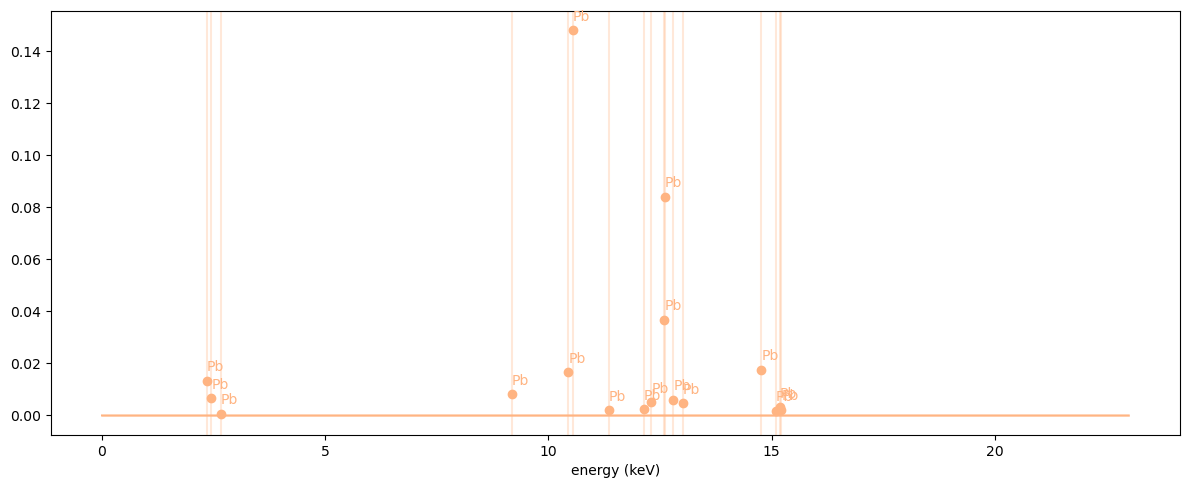

In [34]:
xf.plot()